### top-tagging example using columnar tools

In [1]:
import hist
import numpy as np
import awkward as ak
from coffea.analysis_tools import PackedSelection
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from wprime_plus_b.corrections.jec import jet_corrections
from wprime_plus_b.corrections.met import met_phi_corrections

In [2]:
# deepJet tagger threshold
btag_wp = 0.3  # medium working point (2017)

# load events using the NanoAOD schema
events = NanoEventsFactory.from_root(
    "TTToSemiLeptonic.root", schemaclass=NanoAODSchema, entry_stop=500000
).events()
nevents = len(events)

#### event preselection

In [3]:
# select good electrons
good_electrons = (
    (events.Electron.pt >= 30)
    & (np.abs(events.Electron.eta) < 2.4)
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (events.Electron.mvaFall17V2Iso_WP90)
    & (
        events.Electron.pfRelIso04_all < 0.25
        if hasattr(events.Electron, "pfRelIso04_all")
        else events.Electron.pfRelIso03_all < 0.25
    )
)
n_good_electrons = ak.sum(good_electrons, axis=1)
electrons = events.Electron[good_electrons]

# select good muons
good_muons = (
    (events.Muon.pt >= 35)
    & (np.abs(events.Muon.eta) < 2.4)
    & (events.Muon.tightId)
    & (
        events.Muon.pfRelIso04_all < 0.25
        if hasattr(events.Muon, "pfRelIso04_all")
        else events.Muon.pfRelIso03_all < 0.25
    )
)
n_good_muons = ak.sum(good_muons, axis=1)
muons = events.Muon[good_muons]

# select good taus
good_taus = (
    (events.Tau.idDeepTau2017v2p1VSjet > 8)
    & (events.Tau.idDeepTau2017v2p1VSe > 8)
    & (events.Tau.idDeepTau2017v2p1VSmu > 1)
    & (np.abs(events.Tau.eta) < 2.3)
    & (events.Tau.pt > 20)
    & (events.Tau.dz < 0.2)
)
n_good_taus = ak.sum(good_taus, axis=1)
taus = events.Tau[good_taus]

# select good jets
# apply JEC/JER corrections to MC jets (propagate corrections to MET)
corrected_jets, met = jet_corrections(events, "2017")
good_jets = (
    (corrected_jets.pt >= 20)
    & (np.abs(corrected_jets.eta) < 2.4)
    & (corrected_jets.isTightLeptonVeto)
)
n_good_jets = ak.sum(good_jets, axis=1)
jets = corrected_jets[good_jets]

# apply MET phi corrections
met_pt, met_phi = met_phi_corrections(
    met_pt=met.pt,
    met_phi=met.phi,
    npvs=events.PV.npvs,
)
met["pt"], met["phi"] = met_pt, met_phi

#### event selection

In [4]:
# make a PackedSelection object to store selection masks
selections = PackedSelection()

# add muon trigger mask 
selections.add("trigger_mu", events.HLT["IsoMu27"])

# check that there be a minimum MET greater than 50 GeV
selections.add("met_pt", met.pt > 50)

# check that jets dont overlap with our selected muons
njets = 4
pad_jets = ak.pad_none(jets, njets)
for i in range(njets):
    jet_i = pad_jets[:, i]
    selections.add(f"muon_jet{i}_dr", jet_i.delta_r(ak.firsts(muons)) > 0.4)
    
# add number of leptons and jets
selections.add("one_muon", n_good_muons == 1)
selections.add("tau_veto", n_good_taus == 0)
selections.add("atleast_4j", ak.num(jets) >= njets)
selections.add("atleast_1b", ak.sum(jets.btagCSVV2 > btag_wp, axis=1) >= 1)
selections.add("electron_veto", n_good_electrons == 0)

# define channel selection and select region jets
region_selections = [name for name in selections.names]
region_selection = selections.all(*region_selections)
region_jets = jets[region_selection]

#### reconstruct hadronic top as bjj system

In [5]:
# top (bjj) candidates
trijet = ak.combinations(region_jets, 3, fields=["j1", "j2", "j3"])
# calculate four-momentum of bjj system
trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3
# get maximum btagDeepFlavB score
trijet["max_btag"] = np.maximum(
    trijet.j1.btagDeepFlavB,
    np.maximum(trijet.j2.btagDeepFlavB, trijet.j3.btagDeepFlavB),
)
# at least one-btag in bjj candidates
trijet = trijet[trijet.max_btag > btag_wp]
# compute pt and mass of bjj system
trijet_pt = trijet["p4"].pt
trijet_mass = trijet["p4"].mass

# w (jj) candidates mass
dijet_mass = ak.where(
    trijet.j1.btagDeepFlavB > btag_wp,
    (trijet.j2 + trijet.j3).mass,
    (
        ak.where(
            trijet.j2.btagDeepFlavB > btag_wp,
            (trijet.j1 + trijet.j3).mass,
            (trijet.j1 + trijet.j2).mass,
        )
    ),
)
# compute chi square 
top_mass_pdg = 173.1
top_sigma = 35.02
w_sigma = 20.09
w_mass_pdg = 80.4
chi_sq = ((trijet_mass - top_mass_pdg) / top_sigma) ** 2 + (
    (dijet_mass - w_mass_pdg) / w_sigma
) ** 2

# get hadtop candidate mask
chisq_threshold = 3.0
small_chi_sq_mask = chi_sq < chisq_threshold
has_hadt_candidate_mask = ak.fill_none(ak.any(small_chi_sq_mask, axis=1), False)
has_hadt_candidate_mask

<Array [True, True, True, ... True, False] type='30256 * bool'>

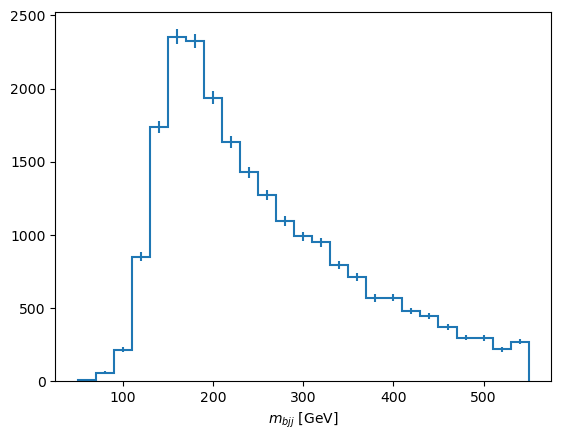

In [6]:
# find the bjj triplet with max pt and chi2 < threshold
trijet_pt_small_chi_sq = trijet_pt[small_chi_sq_mask]
trijet_candidate_mass = trijet_mass[
    ak.argmax(trijet_pt_small_chi_sq, keepdims=True, axis=1)
]
histogram = hist.Hist(
    hist.axis.Regular(
        bins=25, start=50, stop=550, name="mbjj", label="$m_{bjj}$ [GeV]"
    ),
    hist.storage.Weight(),
)
histogram.fill(mbjj=ak.fill_none(ak.flatten(trijet_candidate_mass), False)).plot1d();